## Here are some explanations relating to the numbered questions:

## please note these applied to the check-in at the time it was done, i made significant changes for re-evaluation for the final project appendix
1. We chose 'Learning_Disabilities' as our binary categorical response variable. Its values are 'Yes' and 'No'

2. We chose 'Exam_Score' as our predictor varriable. We expect to see some sort of negative correlation, which means that, as Exam_Score increases, the likelihood of Learning_Disabilities being 'Yes' should decrease.

3. See code
4. See code

5. We initially ran the code with the default threshold of 0.5. We then tested lower thresholds to see if they would improve the model's ability to identify a Positive case. Upon testing the lower thresholds, the accuracy of the model fell significantly. So, we decided to proceed with the default threshold and our model obtained an accuracy of roughly 89%. This is a great metric, but it is worth noting that the model had a TPR of 0.0 and a TNR of 1.0, meaning that the model simply predicted 'No' for all cases of having a 'Learning Disability.' This speaks a lot towards the skew of the dataset, as the model technically performed well despite making the same, majority based decision for all data points. As the correlation between our predictor and response variable was quite slight (around -0.08), it makes sense that the model chose a blanket answer to predict the majority of cases.
This dataset just simply does not have great binary categorical options, and more data points with a learning disability would help to test the model more rigorously.

In [215]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import pointbiserialr
from sklearn.linear_model import LogisticRegression

complete_data = pd.read_csv("StudentPerformanceFactors.csv")

In [216]:
# Note: Originally (at the time of this check-in), we only used Learning Disability as a predictor variable.
# Upon revisiting, we will use the 7 main predictor features (Exam_Score is a main feature, but it's our target, not predictor) 
# decided upon for our final project methodology which are the following:
main_features = ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Parental_Involvement', 'Learning_Disabilities', 'Access_to_Resources', 'Tutoring_Sessions', 'Exam_Score']
## Note: The Final Project included Distance_From_Home as an 8th predictor, but it was shown to have missingness so I excluded it here. All other values are unproblematic, as shown in code in the final project.
# Also, just based on simple logic, Distance_From_Home would most likely not be that impactful.

In [217]:
## In Logistic Regression, the dependent response variable is categorical / non-continuous / binary.
# So, Exam_score will have to be mapped using a threshold.
# After researching the dataset, I could not find any information related to the school's grade scale
# and what constitutes a passing grade, therefore I will use the standard value of 60%. 

# Exam_Score will be mapped as follows using the Passed_Exam variable:
    # If Exam_Score >= 60: Passed_Exam = 1
    # Else: Passed_Exam = 0

# Extract our main features
data = complete_data[main_features].copy()
pass_threshold = 60

# Encode Exam_Score using pass_threshold to new Passed_Exam column
data['Passed_Exam'] = (data['Exam_Score'] >= pass_threshold).astype(int)

## split data into predictors and target, Exam_Score column no longer needed for both
X = data.drop(['Exam_Score', 'Passed_Exam'], axis=1)
y = data['Passed_Exam']

print(X.head())
print(y.head())


   Hours_Studied  Attendance  Previous_Scores Parental_Involvement  \
0             23          84               73                  Low   
1             19          64               59                  Low   
2             24          98               91               Medium   
3             29          89               98                  Low   
4             19          92               65               Medium   

  Learning_Disabilities Access_to_Resources  Tutoring_Sessions  
0                    No                High                  0  
1                    No              Medium                  2  
2                    No              Medium                  2  
3                    No              Medium                  1  
4                    No              Medium                  3  
0    1
1    1
2    1
3    1
4    1
Name: Passed_Exam, dtype: int64


In [218]:
## We need to One-Hot Encode 3 of our predictor features:
    # Parental_Involvement [Low, Medium, High]
    # Learning_Disability  [No, Yes]
    # Access_to_Resources  [Low, Medium, High]

categorical_features = ['Parental_Involvement', 'Access_to_Resources', 'Learning_Disabilities']
## this drops one category from each feature to create a baseline, which helps avoid perfect collinear variables
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

print(X_encoded.head())

   Hours_Studied  Attendance  Previous_Scores  Tutoring_Sessions  \
0             23          84               73                  0   
1             19          64               59                  2   
2             24          98               91                  2   
3             29          89               98                  1   
4             19          92               65                  3   

   Parental_Involvement_Low  Parental_Involvement_Medium  \
0                      True                        False   
1                      True                        False   
2                     False                         True   
3                      True                        False   
4                     False                         True   

   Access_to_Resources_Low  Access_to_Resources_Medium  \
0                    False                       False   
1                    False                        True   
2                    False                        True  

In [219]:
# splitting into training and test, with test being 20% of the size
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [220]:
## Apply Standardization after initial runs to see if it improves accuracy
# Standardize numeric features
numeric_features = ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Tutoring_Sessions']

scaler = StandardScaler()
scaler.fit(X_train[numeric_features])

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])


In [221]:
# fit the model
model = LogisticRegression(max_iter=1000)

##model.fit(X_train, y_train)
## for checking if standardization helps
model.fit(X_train_scaled, y_train)

## get predictions
##y_pred = model.predict(X_test)
y_pred = model.predict(X_test_scaled)


Accuracy: 0.9931921331316188
Prediction Error: 0.006807866868381196
True Positive Rate (TPR): 0.9977116704805492
True Negative Rate (TNR): 0.45454545454545453


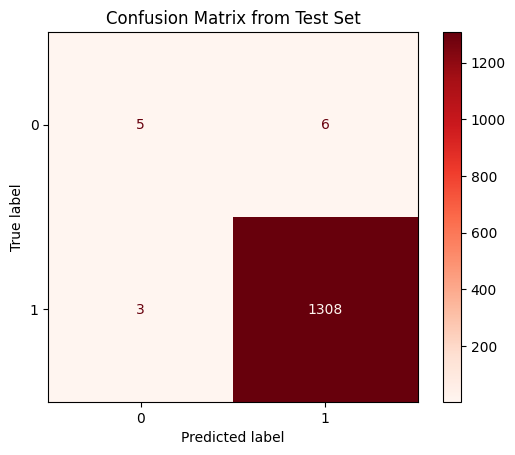

In [222]:
## check some statistics
accuracy = accuracy_score(y_test, y_pred)
prediction_error = 1 - accuracy
true_positive_rate = recall_score(y_test, y_pred)  # TPR
true_negative_rate = recall_score(y_test, y_pred, pos_label=0)  # TNR

print(f"Accuracy: {accuracy}")
print(f"Prediction Error: {prediction_error}")
print(f"True Positive Rate (TPR): {true_positive_rate}")
print(f"True Negative Rate (TNR): {true_negative_rate}")

# create confusion matrix to view spread of results
cm = confusion_matrix(y_test, y_pred)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix from Test Set")
plt.show()

## I had some code to perform 5-fold cross validation and and plotting of ROC for this new data direction, but I removed it because class imbalance was causing interpretation issues and I believe the Confusion Matrix is more intuitive to helping prove our point here

In [223]:
## start of old, original check-in code
## since some variable names got changed, this probably wont run
# see the version of this file one commit ago to view the original code

# using the same code from the previous check-in, we'll split the data into training, validation, and test sets
# Next, divide the new dataframe into 3 different data sets using a 60:20:20 split
# We chose 60:20:20 as opposed to 80:10:10 or somwhere in between to decrease the liklihood of overfitting, since the metrics used are potentially subseptible to overfitting


train_and_validation_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

train_df, validation_df = train_test_split(train_and_validation_df, test_size=0.25, random_state=42)

train_df.to_csv('Student_Performance_train.csv', index=False)
validation_df.to_csv('Student_Performance_validation.csv', index=False)
test_df.to_csv('Student_Performance_test.csv', index=False)

In [224]:
## calculate correlation between our two variables using the testing set

corr_coef, _ = pointbiserialr(train_df[response_variable], train_df[predictor_variable])

print("Train Correlation:", corr_coef)

## calculate correlation between our two variables using the validation set

corr_coef, _ = pointbiserialr(validation_df[response_variable], validation_df[predictor_variable])

print("Validation Correlation:", corr_coef)

## calculate correlation between our two variables using the test set

corr_coef, _ = pointbiserialr(test_df[response_variable], test_df[predictor_variable])

print("Test Correlation:", corr_coef)

TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [ ]:

x_train = train_df[[predictor_variable]]
y_train = train_df[response_variable]

#training the model
model = LogisticRegression()
lr_model = model.fit(x_train, y_train)
#making predictions
y_pred = lr_model.predict(x_train)

#calculating the confusion matrix and other metrics
c_m = confusion_matrix(y_train, y_pred)
print(c_m)

accuracy = accuracy_score(y_train, y_pred)
prediction_error = 1 - accuracy
true_positive_rate = recall_score(y_train, y_pred)  # TPR
true_negative_rate = recall_score(y_train, y_pred, pos_label=0)  # TNR

print(f"Accuracy: {accuracy}")
print(f"Prediction Error: {prediction_error}")
print(f"True Positive Rate (TPR): {true_positive_rate}")
print(f"True Negative Rate (TNR): {true_negative_rate}")

# 5-fold cross-validation on validation set
X_val = validation_df[[predictor_variable]]
y_val = validation_df[response_variable]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# calculate auc and accuracy across the folds
auc_scores = cross_val_score(model, X_val, y_val, cv=cv, scoring='roc_auc')
accuracy_scores = cross_val_score(model, X_val, y_val, cv=cv, scoring='accuracy')

print("AUC Scores for each fold:", auc_scores)
print("Average AUC:", np.mean(auc_scores))
print("Accuracy Scores for each fold:", accuracy_scores)
print("Average Accuracy:", np.mean(accuracy_scores))

# plot auc curve
model.fit(X_val, y_val)  # Fit model to validation data for ROC curve plotting
y_val_proba = model.predict_proba(X_val)[:, 1]  # Probability of the positive class

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
auc = roc_auc_score(y_val, y_val_proba)

fig = go.Figure()

fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC Curve (AUC = {auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Random'))

fig.update_layout(
    title="ROC Curve on Validation Set",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    showlegend=True
)

fig.show()


[[3526    0]
 [ 437    0]]
Accuracy: 0.8897300025233409
Prediction Error: 0.11026999747665911
True Positive Rate (TPR): 0.0
True Negative Rate (TNR): 1.0
AUC Scores for each fold: [0.52060199 0.68205728 0.64921308 0.58327219 0.65495231]
Average AUC: 0.6180193686835939
Accuracy Scores for each fold: [0.89056604 0.89056604 0.89393939 0.89015152 0.89015152]
Average Accuracy: 0.8910748999428245
